### Importando bibliotecas

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay,f1_score,confusion_matrix,recall_score,precision_score,accuracy_score

### 1. Carregando os dados

In [6]:
import os
import pandas as pd

caminho = 'C:\\Users\\lucas\\Downloads\\classificacao_pneumonia\\classificacao_pneumonia\\dataset'

labels = ['train', 'test']
data = []

for folder in labels:
    folder_path = os.path.join(caminho, folder)
    for label in ['NORMAL', 'PNEUMONIA']:
        label_folder = os.path.join(folder_path, label)
        if os.path.exists(label_folder):  # Verifica se a pasta existe
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.jpeg') or file_name.endswith('.png') or file_name.endswith('.jpg'):
                    file_path = os.path.join(label_folder, file_name)
                    data.append([file_path, label.lower()])

df = pd.DataFrame(data, columns=['file_path', 'label'])


### 1.1 Transformando as saídas em 0 e 1

In [7]:
# transformando as labels em 0 e 1
df['label'].unique()
df['label']=df['label'].map({'normal':0,'pneumonia':1})

In [8]:
df['label'].dtype

dtype('int64')

In [9]:
df

,file_path,label
0,C:\Users\lucas\Downloads\classificacao_pneumon...,0
1,C:\Users\lucas\Downloads\classificacao_pneumon...,0
2,C:\Users\lucas\Downloads\classificacao_pneumon...,0
3,C:\Users\lucas\Downloads\classificacao_pneumon...,0
4,C:\Users\lucas\Downloads\classificacao_pneumon...,0
...,...,...
5835,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5836,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5837,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5838,C:\Users\lucas\Downloads\classificacao_pneumon...,1


### 1.2 Exibindo as 25 primeiras imagens

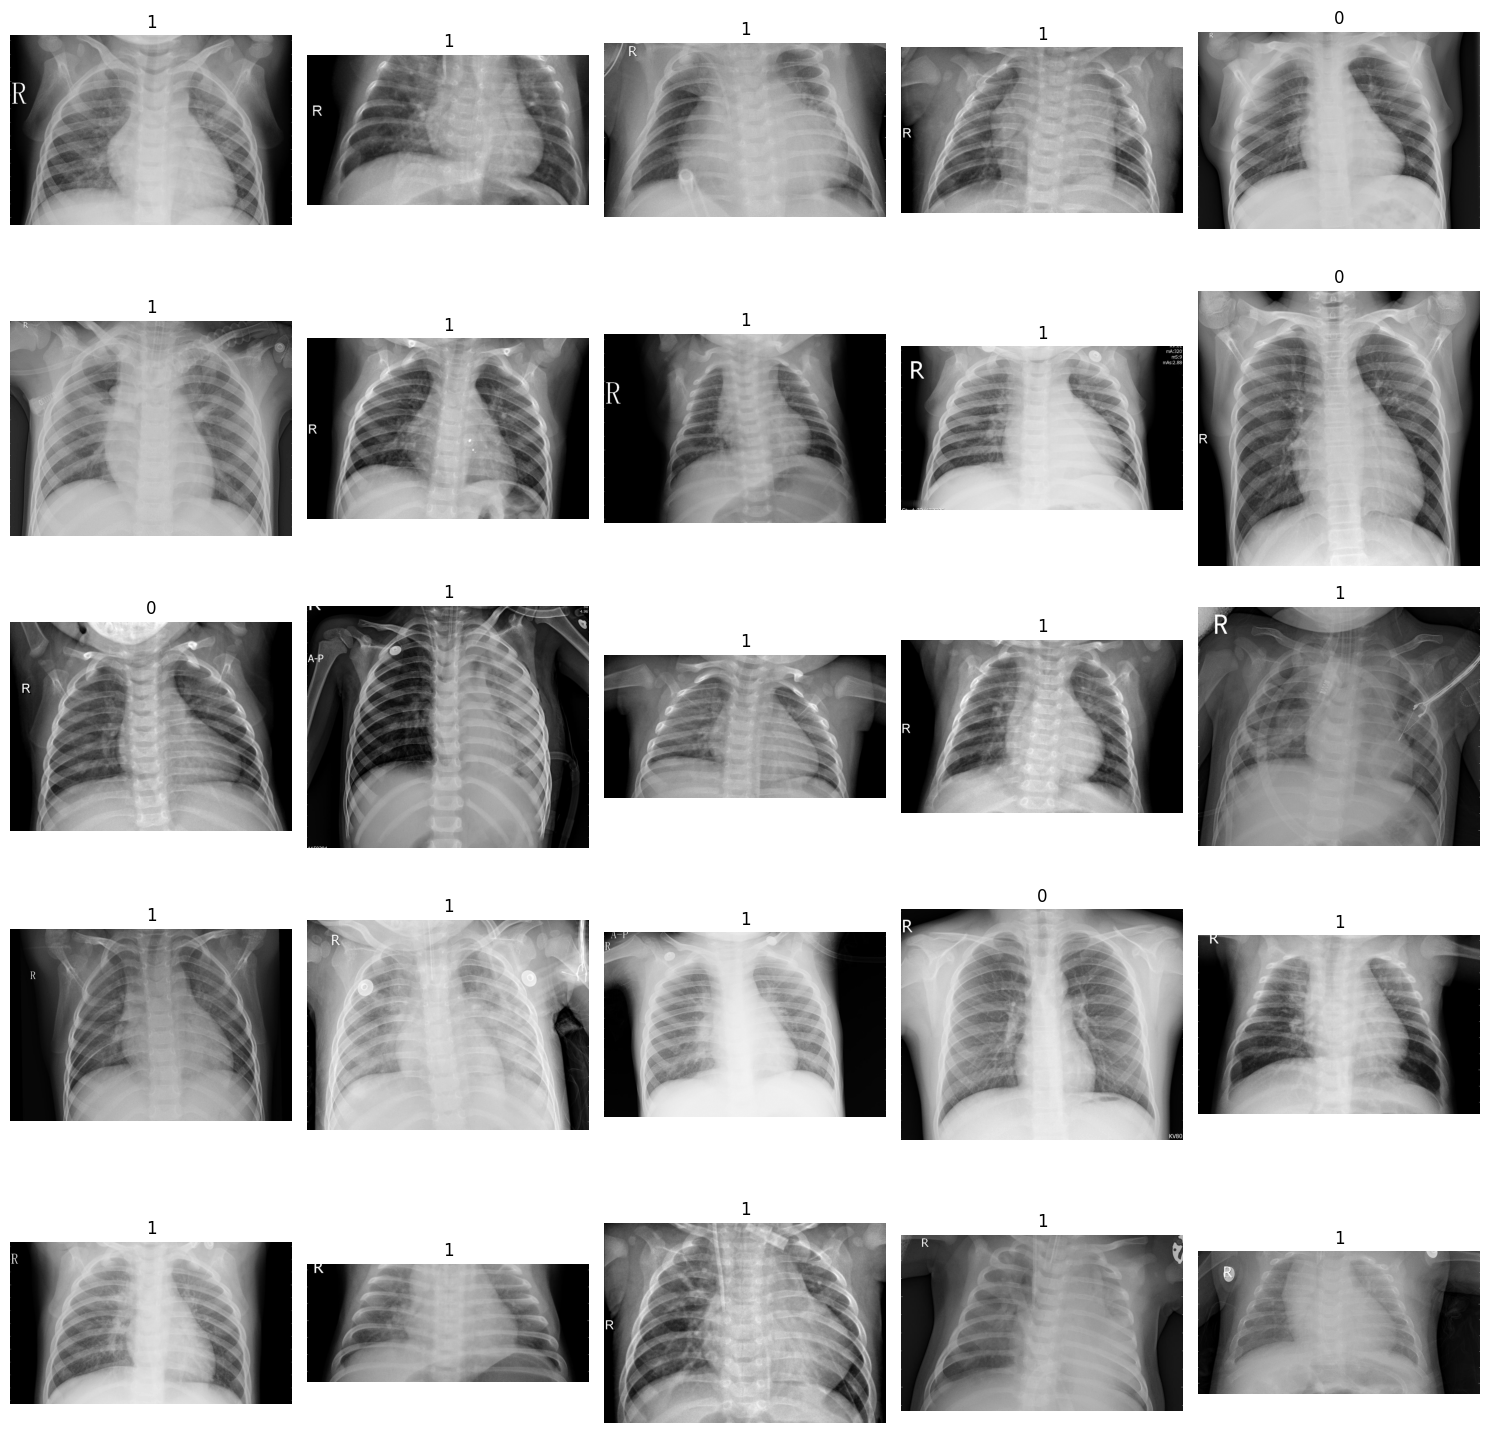

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    ax = axes.flatten()[i]
    row = df.sample(1).iloc[0]
    img = cv2.imread(row['file_path'])
    img_norm = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_normalized = img_norm / 255.0
    
    ax.imshow(img_gray_normalized, cmap='gray')
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


### 1.3 Exibindo as informações dos dados

In [11]:
df.shape

(5840, 2)

In [12]:
df.head(10)

,file_path,label
0,C:\Users\lucas\Downloads\classificacao_pneumon...,0
1,C:\Users\lucas\Downloads\classificacao_pneumon...,0
2,C:\Users\lucas\Downloads\classificacao_pneumon...,0
3,C:\Users\lucas\Downloads\classificacao_pneumon...,0
4,C:\Users\lucas\Downloads\classificacao_pneumon...,0
5,C:\Users\lucas\Downloads\classificacao_pneumon...,0
6,C:\Users\lucas\Downloads\classificacao_pneumon...,0
7,C:\Users\lucas\Downloads\classificacao_pneumon...,0
8,C:\Users\lucas\Downloads\classificacao_pneumon...,0
9,C:\Users\lucas\Downloads\classificacao_pneumon...,0


In [9]:
df.tail(10)

,file_path,label
5830,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5831,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5832,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5833,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5834,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5835,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5836,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5837,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5838,C:\Users\lucas\Downloads\classificacao_pneumon...,1
5839,C:\Users\lucas\Downloads\classificacao_pneumon...,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  5840 non-null   object
 1   label      5840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [13]:
# Verificando as dimensões da imagem
img = cv2.imread(df.iloc[0]['file_path'])

altura, largura, d = img.shape
print(img.shape)
print(f"Dimensão da imagem: {largura}x{altura}")

(1858, 2090, 3)
Dimensão da imagem: 2090x1858


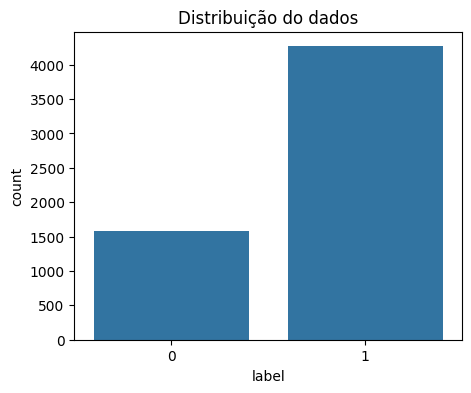

In [14]:
# exibindo a quantidade de registros
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='label')
plt.title('Distribuição do dados')
plt.show()

### 2.0 Normalizando os dados

In [15]:
norm_img = []

for img_path in df['file_path']:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega como escala de cinza
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    norm_img.append(img[..., np.newaxis])  # Adiciona uma nova dimensão para o canal

X = np.array(norm_img, dtype='float32')
y = df['label'].values


In [16]:
len(norm_img) # quantidade de dados normalizados

5840

### 2.1 Dados de teste e treino

In [17]:
X = np.array(norm_img)
y = df['label']

### 2.2 Separação dos dados

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Analisando as dimensões de treino e de teste

In [19]:
x_train.shape, y_train.shape

((4672, 128, 128, 1), (4672,))

In [20]:
x_test.shape, y_test.shape

((1168, 128, 128, 1), (1168,))

### 3.0 Modelo da rede CNN

In [59]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding ="same", input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

# input_shape=(128, 128, 1): Define a forma de entrada da imagem como 128x128 pixels com 1 canal
 
# padding="same": Mantém o tamanho da entrada e da saída da convolução iguais   

# MaxPooling2D(pool_size=(2, 2), strides=(2, 2)): pooling (subamostragem) 
# que reduz a dimensionalidade da imagem,  mantendo as características principais

# O parâmetro strides=(2, 2) desloca deslocada 2 pixels em cada direção, 
# reduzindo a imagem pela metade em termos de largura e altura

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(256, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,603,265 (6.12 MB)

 Trainable params: 1,603,265 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
# aplicando o critério de parada e patience de 4
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [62]:
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 786ms/step - accuracy: 0.6723 - loss: 1.4479 - val_accuracy: 0.7390 - val_loss: 0.5834
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 752ms/step - accuracy: 0.7320 - loss: 0.5840 - val_accuracy: 0.7636 - val_loss: 0.5174
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 765ms/step - accuracy: 0.7650 - loss: 0.4799 - val_accuracy: 0.7957 - val_loss: 0.4097
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 812ms/step - accuracy: 0.8317 - loss: 0.3726 - val_accuracy: 0.8385 - val_loss: 0.4972
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 754ms/step - accuracy: 0.8435 - loss: 0.3604 - val_accuracy: 0.8738 - val_loss: 0.3091
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 821ms/step - accuracy: 0.8746 - loss: 0.3005 - val_accuracy: 0.8963 - val_loss: 0.2963
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 798ms/step - accuracy: 0.8694 - loss: 0.2839 - val_accuracy: 0.9112 - val_loss: 0.2720
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 829ms/step - accuracy: 0.8967 - loss: 0.2439 - val_accu

In [63]:
# salvar o loss
pd.DataFrame(history.history).to_csv('loss.csv', index=False)


In [64]:
# salvar o modelo
model.save('model.keras')

In [21]:
import tensorflow as tf
model = tf.keras.models.load_model('model.keras')

### 3.1 Visualizando o erro e a acurácia

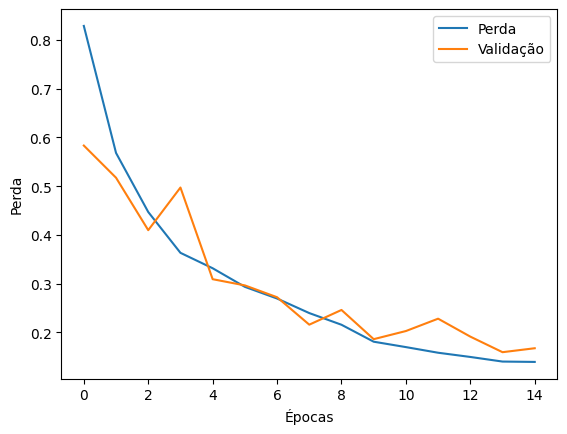

In [65]:
plt.plot(history.history['loss'], label='Perda')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

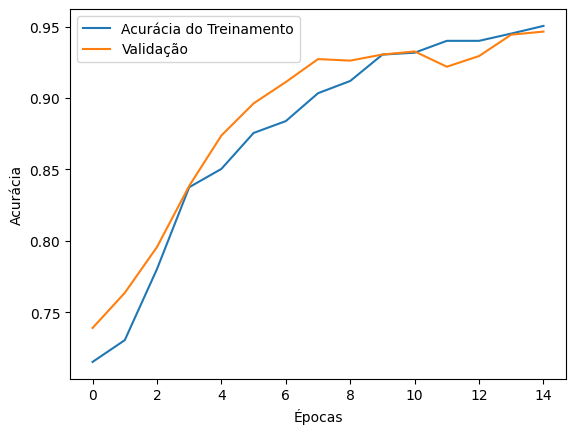

In [66]:
plt.plot(history.history['accuracy'], label='Acurácia do Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [22]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Acurácia do modelo: {acc * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9539 - loss: 0.1578
Acurácia do modelo: 95.03%


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


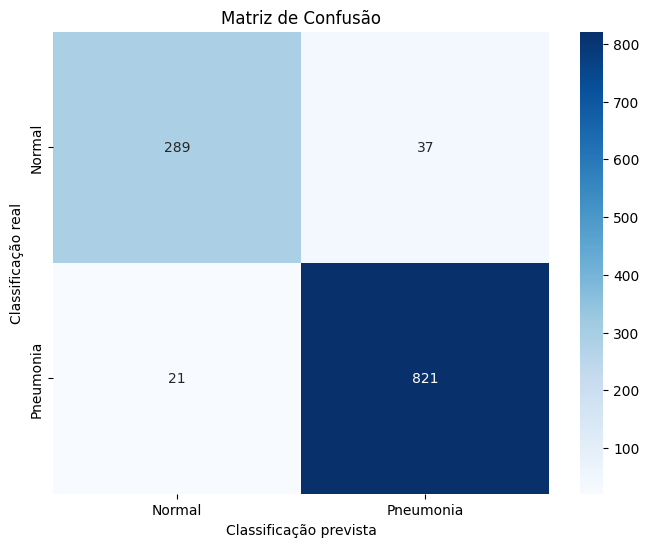

In [23]:
# Previsão das classes com base no limiar de 0.5
predict = model.predict(x_test)
predicted_classes = (predict > 0.5).astype(int)

# Gera a matriz de confusão
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Rótulos das classes
labels = ['Normal', 'Pneumonia']

# Cria o heatmap com rótulos
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Classificação prevista')
plt.ylabel('Classificação real')
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Converter probabilidades para rótulos binários (se `predict` for contínuo)
predict_binary = np.where(predict >= 0.5, 1, 0)  # Para classificação binária

# Calcular acurácia
accuracy = accuracy_score(y_test, predict_binary)
print("Acurácia:", accuracy * 100, "%")

# Calcular precisão
precision = precision_score(y_test, predict_binary, average='macro')
print("Precisão:", precision * 100, "%")

# Calcular recall
recall = recall_score(y_test, predict_binary, average='macro')
print("Recall:", recall * 100, "%")

# Calcular F1 score
f1 = f1_score(y_test, predict_binary, average='macro')
print("F1-score:", f1 * 100, "%")


Acurácia: 95.03424657534246 %
Precisão: 94.4567260696293 %
Recall: 93.07812249537328 %
F1-score: 93.73436921938587 %


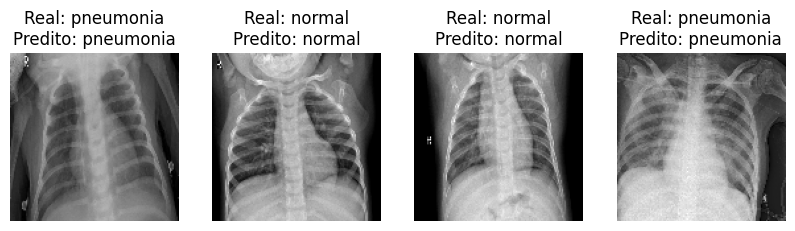

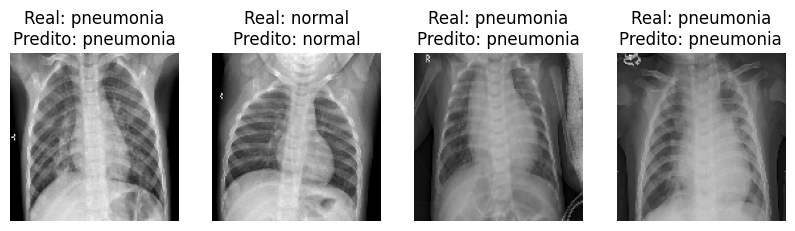

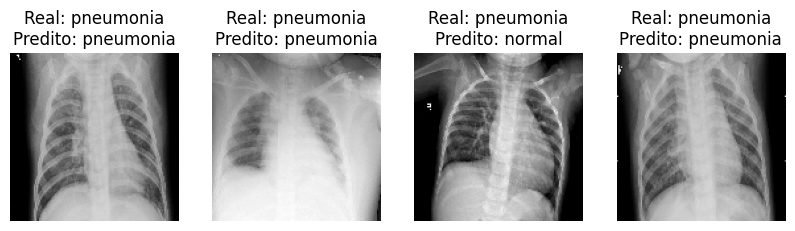

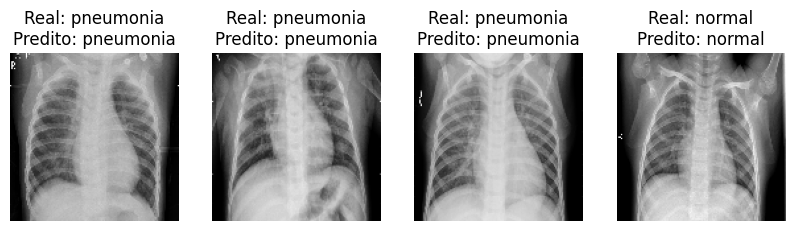

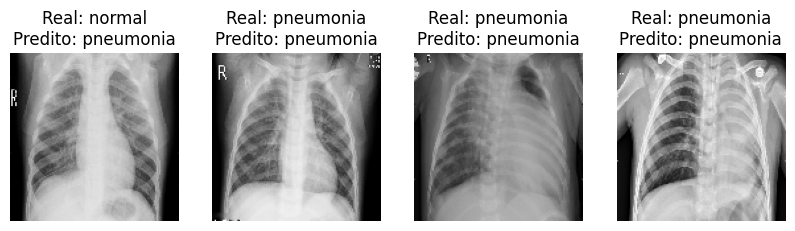

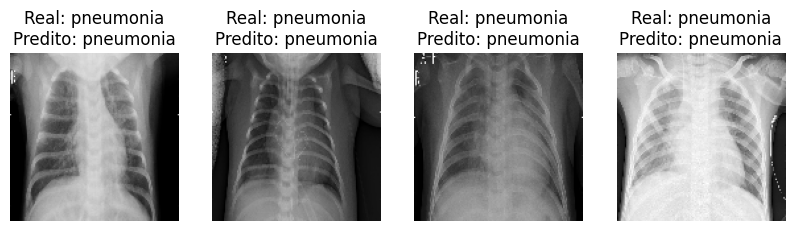

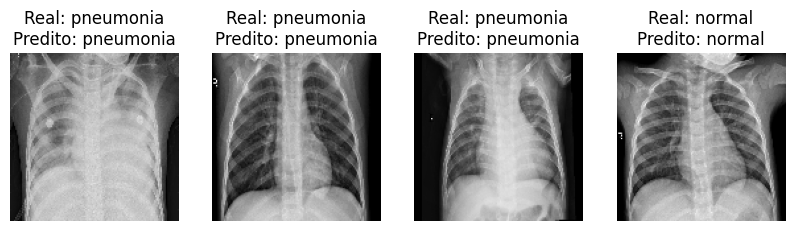

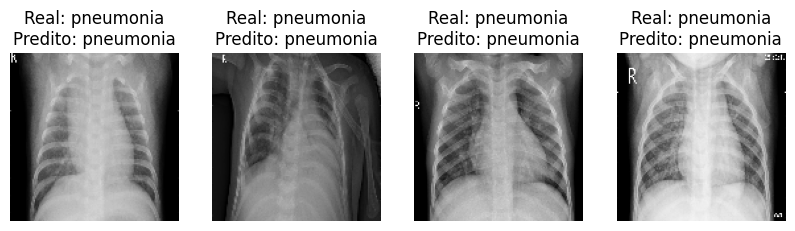

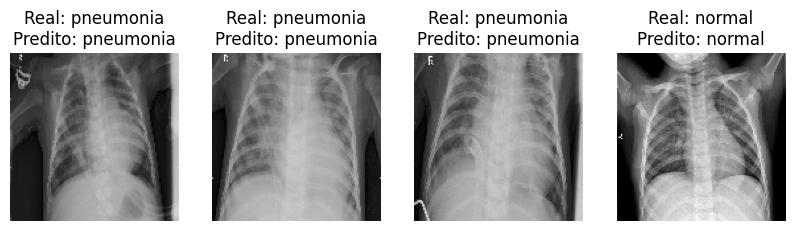

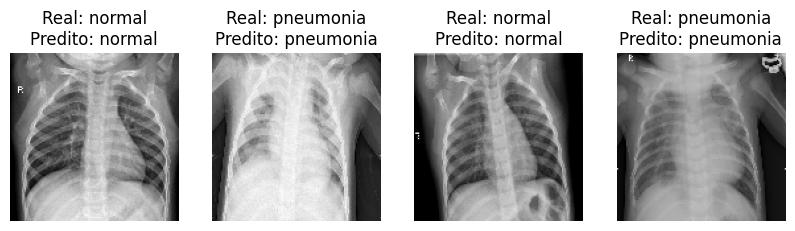

In [70]:
import matplotlib.pyplot as plt

n = 4
classes = ['normal', 'pneumonia'] 
preds = (predict > 0.5).astype(int)  # Converte as previsões em 0 ou 1 

for t in range(10):
    plt.figure(figsize=(10, 10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(x_test[i], cmap='gray')  # Exibe as imagens no formato correto
        real_label = int(y_test[i]) if isinstance(y_test, np.ndarray) else int(y_test.iloc[i])
        predicted_label = int(preds[i][0])  # Certifique-se de que a predição é binária
        plt.title('Real: {}\nPredito: {}'.format(classes[real_label], classes[predicted_label]))
        plt.axis('off')
    plt.show()


### 4.0 IA explicável

In [31]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Função para normalizar os valores SHAP
def normalize_shap_values(shap_values, epsilon=1e-8):
    normalized_shap = []
    for val in shap_values:
        min_val = np.min(val)
        max_val = np.max(val)
        range_val = max_val - min_val + epsilon  # Evita divisão por zero
        normalized_shap.append((val - min_val) / range_val)  # Normalizar para [0, 1]
    return np.array(normalized_shap)

# Selecionar algumas imagens de fundo para SHAP (100 amostras aleatórias do treino)
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Inicializar o DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Explicar as previsões para as primeiras 10 imagens de teste
shap_values = explainer.shap_values(x_test[:10])

# Normalizar os valores SHAP para o intervalo [0, 1]
normalized_shap_values = normalize_shap_values(shap_values)



c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [28]:
y_test = np.array(y_test)
y_test

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [29]:
predict

array([[9.9150836e-01],
       [9.0379417e-03],
       [1.9212076e-01],
       ...,
       [1.0000000e+00],
       [9.1392845e-01],
       [2.5489242e-04]], dtype=float32)

<Figure size 1500x500 with 0 Axes>

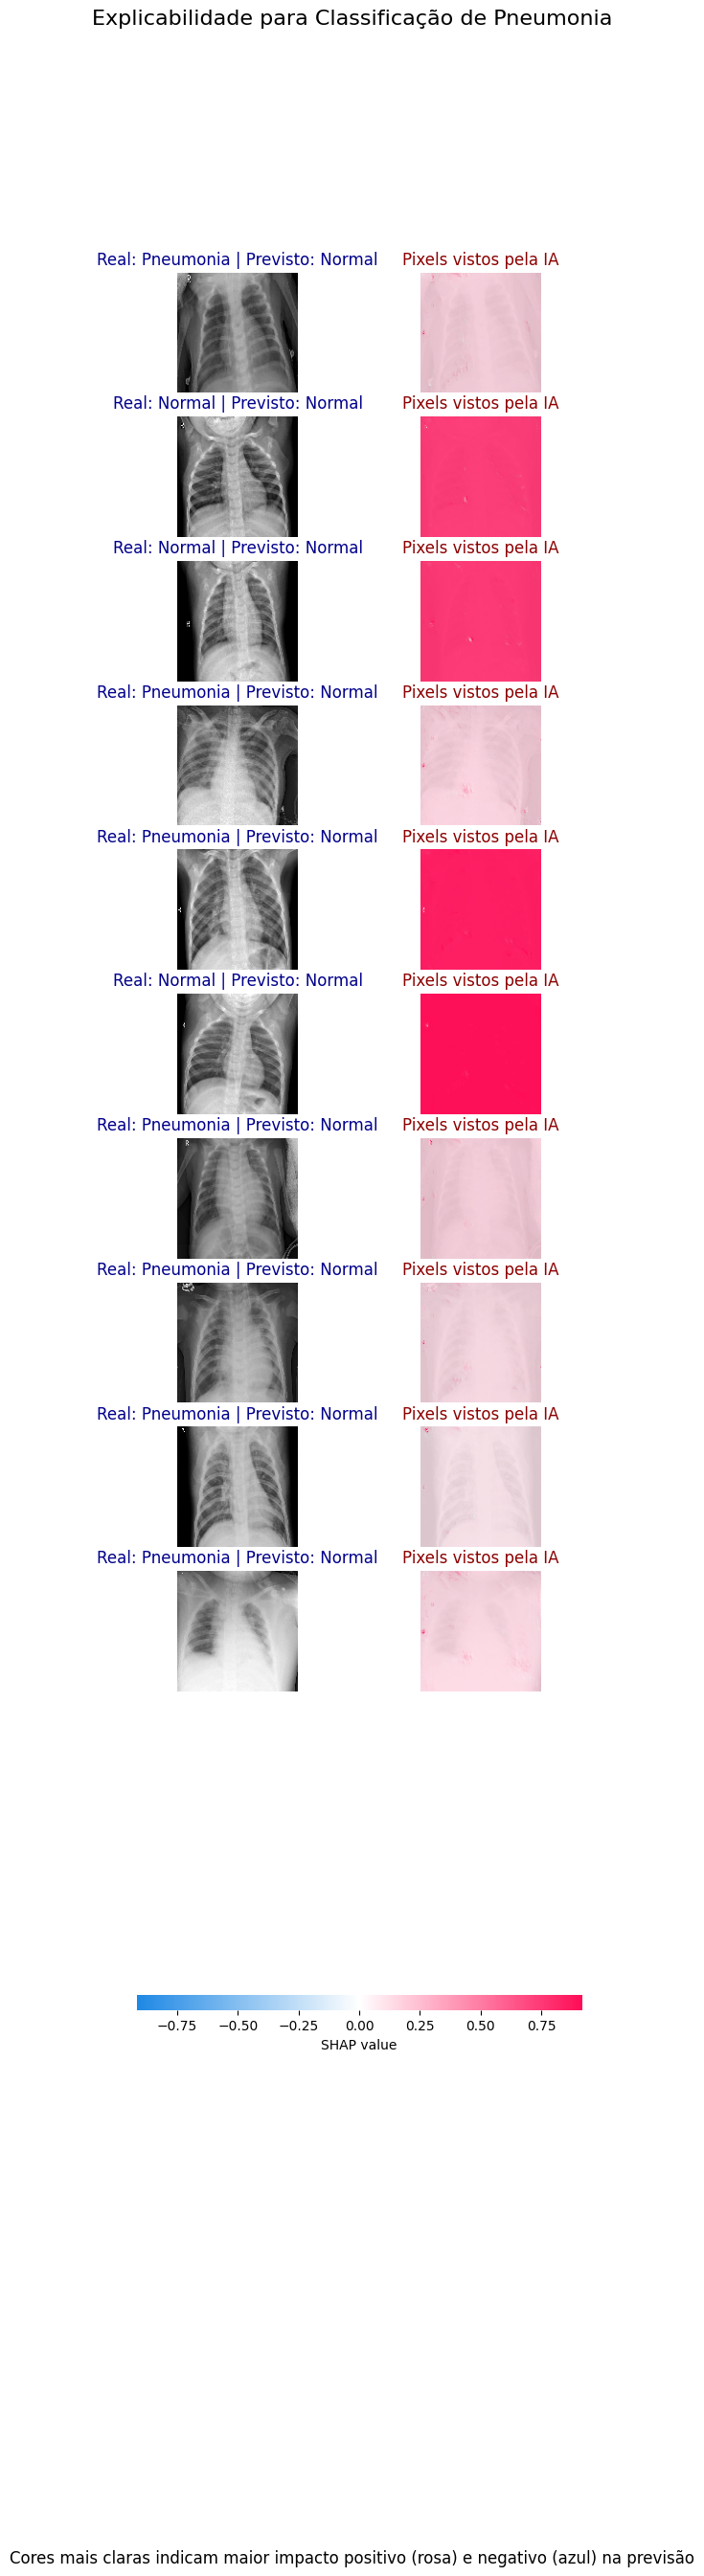

In [39]:

titles_left = [f"Real: {'Pneumonia' if y_test[i] == 1 else 'Normal'} | Previsto: {'Pneumonia' if predict[i] == 1 else 'Normal'}" for i in range(10)]

titles_right = ["Pixels vistos pela IA" for _ in range(10)]

plt.figure(figsize=(15, 5))
shap.image_plot(normalized_shap_values, x_test[:10], show=False)

axes = plt.gcf().axes
for i in range(0, len(titles_left) * 2, 2):
    axes[i].set_title(titles_left[i // 2], fontsize=12, color="darkblue")

for i in range(1, len(titles_right) * 2, 2):
    axes[i].set_title(titles_right[i // 2], fontsize=12, color="darkred")

plt.suptitle('Explicabilidade para Classificação de Pneumonia', fontsize=16)
plt.figtext(0.5, 0.01, "Cores mais claras indicam maior impacto positivo (rosa) e negativo (azul) na previsão", ha="center", fontsize=12)

plt.show()